In [ ]:

import torch
import torch.nn as nn
import einops
import math



class simplenet(nn.Module):
    def __init__(self):
        super(simplenet,self).__init__()
        self.vecs=nn.Parameter(torch.randn([12],requires_grad=True))
        
    
    def forward(self):
        a,b,c,d=self.vecs.chunk(4)
        return torch.einsum('i,j->ij',a,b)+torch.einsum('i,j->ij',c,d)
    

class simplernet(nn.Module):
    def __init__(self,n):
        super(simplernet,self).__init__()
        self.a=nn.Parameter(torch.randn([n],requires_grad=True)/1.0)
        self.b=nn.Parameter(torch.randn([n],requires_grad=True)/1.0)
        self.c=nn.Parameter(torch.randn([n],requires_grad=True)/1.0)
        self.d=nn.Parameter(torch.randn([n],requires_grad=True)/1.0)
        
    
    def forward(self):
        return torch.einsum('i,j->ij',self.a,self.b)+torch.einsum('i,j->ij',self.c,self.d)
    

        



class biggerNet(nn.Module):
    def __init__(self,dim,num):
        super(biggerNet,self).__init__()
        self.cols=nn.Parameter(torch.randn([num,dim],requires_grad=True,dtype=torch.float32)/math.sqrt(num))
        self.rows=nn.Parameter(torch.randn([num,dim],requires_grad=True,dtype=torch.float32)/math.sqrt(num))

    def forward(self):
        outer=torch.einsum('ij, ik -> ijk',self.cols,self.rows)
        return outer.sum(dim=0)
        


In [ ]:
model=biggerNet(3,20)
model()
(model.rows.norm(2,dim=1)*model.cols.norm(2,dim=1)).sqrt().detach().numpy()

array([0.26230884, 0.3357203 , 0.2036532 , 0.39317602, 0.34981224,
       0.23194468, 0.35149246, 0.2701878 , 0.28628075, 0.55980575,
       0.3431646 , 0.1895501 , 0.20602353, 0.48316655, 0.3648572 ,
       0.45552692, 0.10852868, 0.41295424, 0.6547695 , 0.2648464 ],
      dtype=float32)

In [ ]:
import numpy as np
from tqdm import trange,tqdm
torch.manual_seed(7923)

model=biggerNet(12,10)

K=torch.randn([12,1],requires_grad=False)
Q=torch.randn([12,1],requires_grad=False)
Teach=Q @ K.T

K=torch.randn([12,1],requires_grad=False)
Q=torch.randn([12,1],requires_grad=False)

Teach += Q @ K.T

optimizer=torch.optim.AdamW(model.parameters(),lr=0.05,weight_decay=0*1e-1,amsgrad=True)

epochs=30000


norm_arr=[]
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    loss=torch.norm(model()-Teach,2)**2
    # print(loss)
    # loss+=0.01*torch.norm(model.vecs,1)
    # norms=torch.norm(model.vecs.view(4,3),2,dim=1).view(2,2).prod(dim=1).sqrt()
    # norms=[(model.a.norm()*model.b.norm()),(model.c.norm()*model.d.norm())]
    # norms=[(model.b.norm()),(model.d.norm())]
    # loss+=0.1* torch.tensor(norms).sum()
    norms=(model.rows.norm(2,dim=1)*model.cols.norm(2,dim=1)).sqrt().detach().numpy()
    norm_arr.append(norms)

    loss.backward()
    optimizer.step()


    if (epoch+1)%30000==0:
        print(f'epoch: {epoch+1}\t|\tloss: {loss.log10().item():.2f}\t|\tnorms: '+np.array2string(np.log10(norms), precision=1, floatmode='fixed'))#\t|\tnorms: {norms[0]:.2f}, {norms[1]:.2f}')

epoch: 30000	|	loss: -12.38	|	norms: [ 0.3  0.1  0.3  0.3  0.2  0.4  0.2 -0.3 -0.2  0.2]


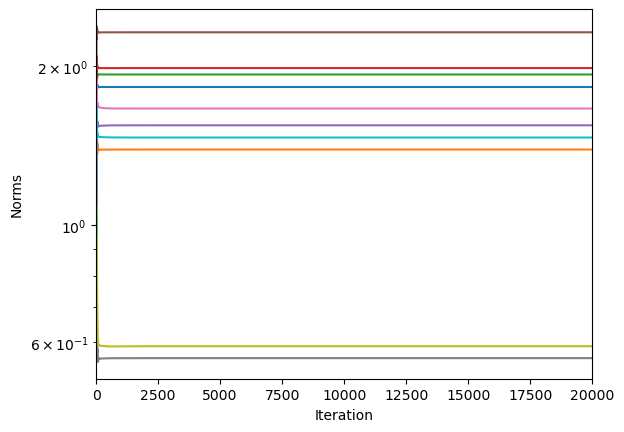

In [ ]:
import matplotlib.pyplot as plt

for line in np.array(norm_arr).T:
    plt.plot(line)

plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Norms')
# plt.ylim(1e-5,10)
plt.xlim(0,20000)
plt.show()

In [ ]:
(1-model().detach()/Teach).abs().log10().view(-1).sort().values

tensor([   -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
           -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
           -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
           -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
           -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
           -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
           -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
           -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
           -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,
           -inf,    -inf, -7.2247, -7.2247, -7.2247, -7.2247, -7.2247, -7.2247,
        -7.2247, -7.2247, -7.2247, -7.2247, -7.2247, -7.2247, -7.2247, -7.2247,
        -7.2247, -6.9237, -6.9237, -6.9237, -6.9237, -6.9237, -6.9237, -6.9237,
        -6.9237, -6.9237, -6.9237, -6.92

In [ ]:
class short(nn.Module):
    def __init__(self):
        super(short,self).__init__()
        self.y=nn.Parameter(torch.randn([1],requires_grad=True,dtype=torch.double))
        self.x=nn.Parameter(torch.randn([1],requires_grad=True,dtype=torch.double))
       
        self.t1=nn.Parameter(torch.randn([1],requires_grad=True,dtype=torch.double))
        self.t2=nn.Parameter(torch.randn([1],requires_grad=True,dtype=torch.double))
        self.q1=nn.Parameter(torch.randn([1],requires_grad=True,dtype=torch.double))
        self.q2=nn.Parameter(torch.randn([1],requires_grad=True,dtype=torch.double))
        
    
    def forward(self,input):
        T1=torch.cos(self.t1)
        T2=torch.cos(self.t2)
        Q1=torch.cos(self.q1)
        Q2=torch.cos(self.q2)

        T12=torch.cos(self.t1-self.t2)
        Q12=torch.cos(self.q1-self.q2)

        return 1+self.x**2+self.y**2-2*self.x*T1*Q1-2*self.y*T2*Q2+2*self.x*self.y*T12*Q12
    



In [ ]:
model=short()

optimizer=torch.optim.SGD(model.parameters(),lr= 10)

for i in range(20):
    model.train()
    optimizer.zero_grad()

    loss=model(1).sum()
    
    optimizer.step()

    print(loss.item())

1.0848221364009287
1.0848221364009287
1.0848221364009287
1.0848221364009287
1.0848221364009287
1.0848221364009287
1.0848221364009287
1.0848221364009287
1.0848221364009287
1.0848221364009287
1.0848221364009287
1.0848221364009287
1.0848221364009287
1.0848221364009287
1.0848221364009287
1.0848221364009287
1.0848221364009287
1.0848221364009287
1.0848221364009287
1.0848221364009287


In [ ]:
# model=short()
model.train()
loss=model(None).sum()
loss.backward()
oprimizer.step()
for name, param in model.named_parameters():
    print(name, param.grad.item(), param.item())



y -4.382595385615131 -0.011813331989359764
x -11.365170701502864 -0.04147588133806347
t1 -0.12328021247151669 0.27765189142157204
t2 -0.13743348349124382 1.2311498137139976
q1 -0.17087148749312517 0.3617193944205535
q2 0.0057330334781476155 -0.09005317162602089


In [ ]:
import torch
import torch.nn as nn

class Short(nn.Module):
    def __init__(self):
        super(Short, self).__init__()
        self.y = nn.Parameter(torch.tensor(0.01, requires_grad=True, dtype=torch.double))#nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.double))
        self.x = nn.Parameter(torch.tensor(1.1, requires_grad=True, dtype=torch.double))#nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.double)/100)
        self.t1 = nn.Parameter(torch.tensor(0, requires_grad=True, dtype=torch.double))
        self.t2 = nn.Parameter(torch.tensor(0, requires_grad=True, dtype=torch.double))
        self.q1 = nn.Parameter(torch.tensor(0, requires_grad=True, dtype=torch.double))
        self.q2 = nn.Parameter(torch.tensor(0, requires_grad=True, dtype=torch.double))
        
    def forward(self):
        T1 = torch.cos(self.t1)
        T2 = torch.cos(self.t2)
        Q1 = torch.cos(self.q1)
        Q2 = torch.cos(self.q2)
        T12 = torch.cos(self.t1 - self.t2)
        Q12 = torch.cos(self.q1 - self.q2)
        return 1 + self.x**2 + self.y**2 - 2 * self.x.abs() * T1 * Q1 - 2 * self.y.abs() * T2 * Q2 + 2 * self.x.abs() * self.y.abs() * T12 * Q12
    

model = Short()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)  # Consider reducing the learning rate

for i in range(1000):
    model.train()
    optimizer.zero_grad()

    loss = model().sum()  # Changed to call the forward method without an argument
    loss+= (model.x.abs().sum()+model.y.abs().sum())/100
    
    loss.backward()  # This is necessary to compute the gradients
    optimizer.step()

    if (i+1)%100:
        print(loss.item())


model.x,model.y

0.0232
0.019000000000000156
0.014736000000000067
0.013224000000000154
0.011688959999999776
0.011144639999999923
0.010592025600000433
0.010396070400000084
0.010197129215999743
0.010126585344000003
0.01005496651776015
0.010029570723840135
0.01000378794639368
0.00999464546058247
0.009985363660701527
0.009982072365809756
0.009978730917852601
0.00997754605169131
0.009976343130426862
0.009975916578609145
0.00997548352695359
0.009975329968299234
0.009975174069703498
0.009975118788587672
0.009975062665093109
0.009975042763891698
0.00997502255943356
0.009975015395000956
0.009975008121396118
0.009975005542200327
0.009975002923702575
0.009975001995192018
0.009975001052533008
0.009975000718269168
0.009975000378911842
0.00997500025857712
0.00997500013640826
0.00997500009308744
0.009975000049106892
0.00997500003351165
0.009975000017678506
0.00997500001206409
0.009975000006364433
0.009975000004343057
0.009975000002291082
0.009975000001563546
0.009975000000824748
0.00997500000056271
0.0099750000002969

(Parameter containing:
 tensor(0.9950, dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor(-2.4672e-17, dtype=torch.float64, requires_grad=True))

In [3]:
import torch

tn=torch.zeros([2,3,3])

In [17]:
lorentz_gens=torch.zeros([6,4,4], dtype=torch.float32)
sig_mat=torch.tensor([[0,-1],[1,0]],requires_grad=False, dtype=torch.float32).view(-1)

# Rotations
lorentz_gens[0,[2,2,3,3],[2,3,2,3]]=sig_mat
lorentz_gens[1,[3,3,1,1],[3,1,3,1]]=sig_mat
lorentz_gens[2,[1,1,2,2],[1,2,1,2]]=sig_mat

# Bosts
lorentz_gens[3,[0,0,1,1],[0,1,0,1]]=sig_mat.abs()
lorentz_gens[4,[0,0,2,2],[0,2,0,2]]=sig_mat.abs()
lorentz_gens[5,[0,0,3,3],[0,3,0,3]]=sig_mat.abs()


In [20]:
inputs.shape

torch.Size([2, 3, 4])

In [35]:
import torch

# Create an example input tensor of shape [d, e, f]
# inputs = torch.randn(2, 3, 4, requires_grad=True)

torch.norm(inputs.view(-1),2)**2, (inputs**2).sum(), (torch.norm(inputs,2,dim=-1)**2).sum()

(tensor(11.2790, grad_fn=<PowBackward0>),
 tensor(11.2790, grad_fn=<SumBackward0>),
 tensor(11.2790, grad_fn=<SumBackward0>))

In [67]:
import sys
import os
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import grad
import torch.nn.functional as F

sys.path.append('../python')

 
from Lorentz_loss import LorentzLoss



sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
import torch
import torch.nn as nn
from torch.autograd import grad
import einops

class LorentzInvariantModel(nn.Module):
    """A simple model that outputs a Lorentz scalar x^T η x."""
    def __init__(self):
        super(LorentzInvariantModel, self).__init__()
        # Minkowski metric η
        self.eta = torch.tensor([1, -1, -1, -1], dtype=torch.float32)

    def forward(self, x):
        # Reshape x to [B, N, 4] where N is number of 4-vectors
        x = einops.rearrange(x, 'B (N d) -> B N d', d=4)
        # Compute x^T η x for each 4-vector
        return torch.einsum('B n i, i, B k i -> B n k', x, self.eta, x).view(B,-1).sum(dim=0)

# Initialize the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = LorentzInvariantModel().to(device)




In [72]:
# Test input tensor (Batch size = 2, each input is 4-dimensional, 2 particles)
test_input = torch.tensor([[1.0, 2.0, 3.0, 4.0, 2.0, 2.0, 2.0, 2.0], 
                           [2.0, 3.0, 4.0, 5.0, 1.0, 1.0, 1.0, 1.0]], dtype=torch.float32, device=device)
model(test_input)

tensor([[-28.,  -8.],
        [-46.,  -2.]])

In [73]:
# Lorentz loss instance for scalar output
lorentz_loss = LorentzLoss(device=device, model=model)


test_input.requires_grad = True

# Compute Lorentz loss for scalar case
loss = lorentz_loss(test_input, spin='scalar')

print("Lorentz Scalar Loss:", loss.item())

torch.Size([2, 2])
torch.Size([2, 8])
torch.Size([2, 2, 4])
Lorentz Scalar Loss: 0.0
